In [1]:
#!git clone https://github.com/darioka/impactdeal-2022.git
#%cd impactdeal-2022
#!pip install -r requirements.txt
#!pip install .

# Feature Engineering - EPC Rating

In this notebook we are going to work on the EPC dataset in order to provide more information to the machine learning model we want to train.

This process of creating, selecting, extracting, transforming variables is known as **feature engineering** in machine learning. Together with cleaning, this is the step where data scientist spend most of their times, as the quality of data and features are the most impactful factors for the performances of a model.

In the following, we will focus on three aspects of the EPC rating dataset:
1. a better solution for missing values in some numeric variables,
2. the creation of new variables,
3. feature extraction from text.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from impactdeal.config.column_names import TARGET
from impactdeal.cleaning import Cleaner

df = pd.read_csv("../data/known_epc_ratings.csv.gz", parse_dates=["INSPECTION_DATE"], infer_datetime_format=True)
df = df.sort_values(["BUILDING_REFERENCE_NUMBER", "INSPECTION_DATE"]).drop_duplicates(subset="BUILDING_REFERENCE_NUMBER", keep="last")

y = df.pop(TARGET)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, stratify=y, random_state=42)

cleaner = Cleaner(text_features=True)
X_train = cleaner.fit_transform(X_train)
X_test = cleaner.transform(X_test)


/home/darioka/anaconda3/envs/impactdeal/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Missing Values

We saw that `NUMBER_HABITABLE_ROOMS`,  `NUMBER_HEATED_ROOMS`, `FIXED_LIGHTING_OUTLETS_COUNT` have many missing values. But while a replacement with the mean was a reasonable solution for `FLOOR_HEIGHT`, these variables strongly depend on other factors, as for example `TOTAL_FLOOR_AREA`.

We will now show how a **linear regression** between floor area and number of rooms could be a better tool to substitute missing data. In practice, we will use another machine learning model to predict `NUMBER_HABITABLE_ROOMS`.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

reg_x_cols = ["TOTAL_FLOOR_AREA"]
reg_y_cols = ["NUMBER_HABITABLE_ROOMS", "NUMBER_HEATED_ROOMS", "FIXED_LIGHTING_OUTLETS_COUNT"]

# the dataset for regression is the part of the train dataset where there are no missing values
reg_dataset = X_train[reg_x_cols + reg_y_cols].dropna()
reg_x = reg_dataset[reg_x_cols]
reg_y_habitable = reg_dataset["NUMBER_HABITABLE_ROOMS"]

Mean absolute difference btw actual and predicted #rooms
-----------------------------------------------------------
1.23 rooms  (BASELINE)
0.81 rooms  (LINEAR REGRESSION)


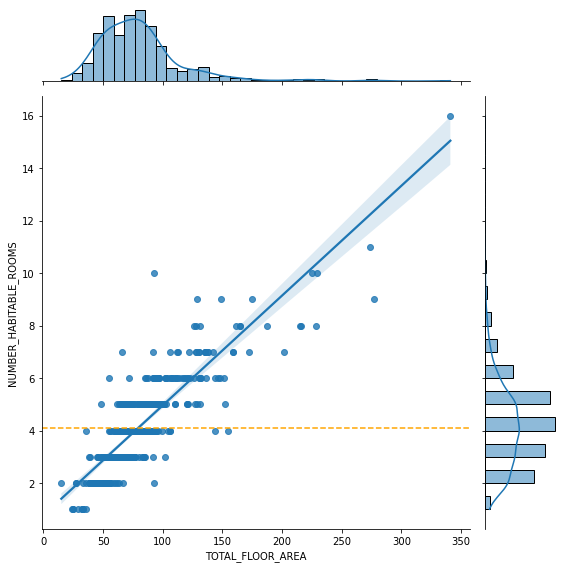

In [4]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

# consider the act of replacing with the mean as a model
# that for every x always predict the same value i.e. the mean of y
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(reg_x, reg_y_habitable)

# use a simple linear regression
linear_model = LinearRegression()
linear_model.fit(reg_x, reg_y_habitable)

# measure performances via cross validation
# with mean absolute error = avg(|y_true - y_pred|)
baseline_score = -cross_validate(
    baseline_model, reg_x, reg_y_habitable, cv=10,
    scoring="neg_mean_absolute_error"
)["test_score"].mean()

linear_score = -cross_validate(
    linear_model, reg_x, reg_y_habitable, cv=10,
    scoring="neg_mean_absolute_error"
)["test_score"].mean()

print("Mean absolute difference btw actual and predicted #rooms")
print("-----------------------------------------------------------")
print(f"{baseline_score:.2f} rooms  (BASELINE)")
print(f"{linear_score:.2f} rooms  (LINEAR REGRESSION)")

plot = sns.jointplot(
    data=reg_dataset.sample(500, random_state=42),
    x="TOTAL_FLOOR_AREA", y="NUMBER_HABITABLE_ROOMS",
    kind="reg", height=8
)
plot.ax_joint.axhline(y=reg_y_habitable.mean(), linestyle="--", color="orange")
plt.show()

Now, it is time to use the new imputing strategy to replace missing values.

The class `impactdeal.preprocessing.RoomsImputer` implements a transformer that fits linear models on `TOTAL_FLOOR_AREA` to predict `NUMBER_HABITABLE_ROOMS`, `NUMBER_HEATED_ROOMS`, and `FIXED_LIGHTING_OUTLETS_COUNT`, and it can be used as a preprocessing step (actually, the linear model therein has some more tricks...).

In [5]:
from impactdeal.preprocessing import RoomsImputer

imputer = RoomsImputer()
imputer.fit(X_train)

X_train[imputer.feature_names_out_] = imputer.transform(X_train)
X_test[imputer.feature_names_out_] = imputer.transform(X_test)

Finally, we keep the same strategy for the other numerical missing data.

In [6]:
from sklearn.impute import SimpleImputer

zero_imputed_cols = [
    "MULTI_GLAZE_PROPORTION",
    "EXTENSION_COUNT",
    "LOW_ENERGY_LIGHTING",
    "NUMBER_OPEN_FIREPLACES",
    "WIND_TURBINE_COUNT"
]
mean_imputed_cols = ["FLOOR_HEIGHT"]

zero_imputer = SimpleImputer(strategy="constant", fill_value=0)
mean_imputer = SimpleImputer(strategy="mean")

X_train[zero_imputed_cols] = zero_imputer.fit_transform(X_train[zero_imputed_cols])
X_test[zero_imputed_cols] = zero_imputer.transform(X_test[zero_imputed_cols])
X_train[mean_imputed_cols] = zero_imputer.fit_transform(X_train[mean_imputed_cols])
X_test[mean_imputed_cols] = zero_imputer.transform(X_test[mean_imputed_cols])

In [7]:
X_train.select_dtypes(float).isnull().sum()

TOTAL_FLOOR_AREA                0
MULTI_GLAZE_PROPORTION          0
EXTENSION_COUNT                 0
NUMBER_HABITABLE_ROOMS          0
NUMBER_HEATED_ROOMS             0
LOW_ENERGY_LIGHTING             0
NUMBER_OPEN_FIREPLACES          0
WIND_TURBINE_COUNT              0
FLOOR_HEIGHT                    0
FIXED_LIGHTING_OUTLETS_COUNT    0
dtype: int64

## New features

This is where our creativity and domain knowledge can be put into practice!

**Can you think of some variables we could add?**

In [8]:
# some new features


X_train["floor_volume"] = X_train["TOTAL_FLOOR_AREA"] * X_train["FLOOR_HEIGHT"]
X_test["floor_volume"] = X_test["TOTAL_FLOOR_AREA"] * X_test["FLOOR_HEIGHT"]

X_train["avg_room_area"] = (X_train["TOTAL_FLOOR_AREA"] / X_train["NUMBER_HABITABLE_ROOMS"]).replace([np.nan, np.inf, -np.inf], 0)
X_test["avg_room_area"] = (X_test["TOTAL_FLOOR_AREA"] / X_test["NUMBER_HABITABLE_ROOMS"]).replace([np.nan, np.inf, -np.inf], 0)

X_train["ratio_heated_rooms"] = X_train["NUMBER_HEATED_ROOMS"] / X_train["NUMBER_HABITABLE_ROOMS"]
X_test["ratio_heated_rooms"] = X_test["NUMBER_HEATED_ROOMS"] / X_test["NUMBER_HABITABLE_ROOMS"]



## Text

So far we neglected possible information coming from the columns whose name ends with `DESCRIPTION`. It was a deliberate choice, because those columns seem to contain free text, which is more difficult to handle. In fact, it cannot be treated as a category, as the unique values would be too many, but there are ways to extract useful features.

First of all, let's take a look at some examples:

In [9]:
example_text = X_train.sample(3, random_state=42)
for c in example_text.columns:
    if c.endswith("DESCRIPTION"):
        print(example_text[c])
        print()

209623                       From main system
301201           Electric immersion, off-peak
425412    Electric immersion, standard tariff
Name: HOTWATER_DESCRIPTION, dtype: object

209623    Solid, no insulation (assumed)
301201            (other premises below)
425412          (another dwelling below)
Name: FLOOR_DESCRIPTION, dtype: object

209623    Fully double glazed
301201    Fully double glazed
425412    Fully double glazed
Name: WINDOWS_DESCRIPTION, dtype: object

209623                    Cavity wall, filled cavity
301201    Cavity wall, as built, insulated (assumed)
425412    Cavity wall, as built, insulated (assumed)
Name: WALLS_DESCRIPTION, dtype: object

209623                      None
301201    Room heaters, electric
425412                      None
Name: SECONDHEAT_DESCRIPTION, dtype: object

209623    Pitched, 100 mm loft insulation
301201           (another dwelling above)
425412           (another dwelling above)
Name: ROOF_DESCRIPTION, dtype: object

209623    Boiler

Based on the few lines we read, it is free text, but it seems somewhat structured. Text is short and similar expressions appear multiple times. If we were experts, probably we would understand the information contained in the text by looking at **keywords**. This suggests that if we could encode the text in a way that highlights the presence or not of a certain word, maybe a dowstream algorithm could be able to find correlations between some words and the actual target.

This procedure of encoding text in an array of numbers representing words is standard in machine learning. The workflow is the following:
1. preprocess text (remove punctuation, split words, ...),
2. build a vocabulary,
3. transform text into a vector of 0-1 indicating the presence of each word.

For example:
```
Hello world!    -->  ["hello", "world"]
Hello, Dario    -->  ["hello", "dario"]

vocabulary = ["hello", "world", "dario"]
                 
Hello world!    ==>  [1, 1, 0]
Hello, Dario    ==>  [1, 0, 1]
```

This representation is similar to [one-hot encoding](https://en.wikipedia.org/wiki/One-hot).

In a text, we could also have the same word multiple times. In that case:

```
Hello hello     ==>  [2, 0, 0]
```

Instead of counts, we could also use **term frequency** i.e. the number of times a word occur divided by the total number of words in the text. This is one of the easiest way to encode text as a numeric vector to make it ready for a machine learning model. Another very well know strategy is [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), where each word in a text sample is encoded with its term frequency, divided by (the logarithm of) the frequency of the same words in all text samples.

In our case, we will use the "count" vectorization implemented in the `scikit-learn` [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

text_cols = [x for x in X_train if x.endswith("DESCRIPTION")]
vectorizers = {}

# for each text column
# create and fit a sklearn vectorizer
# replacing missing data with empty strings
for c in text_cols:
    vectorizers[c] = CountVectorizer(lowercase=True).fit(X_train[c].fillna(""))

In [11]:
print("20 words in the vocabularies of text columns")
print("--------------------------------------------")
for col, v in vectorizers.items():
    print()
    print(col)
    print(list(v.vocabulary_.keys())[:20])

20 words in the vocabularies of text columns
--------------------------------------------

HOTWATER_DESCRIPTION
['from', 'main', 'system', 'electric', 'immersion', 'off', 'peak', 'instantaneous', 'at', 'point', 'of', 'use', 'standard', 'tariff', 'no', 'cylinder', 'thermostat', 'community', 'scheme', 'present']

FLOOR_DESCRIPTION
['suspended', 'no', 'insulation', 'assumed', 'other', 'premises', 'below', 'solid', 'limited', 'average', 'thermal', 'transmittance', '14', 'm²k', '22', 'insulated', 'another', 'dwelling', '15', 'to']

WINDOWS_DESCRIPTION
['partial', 'double', 'glazing', 'fully', 'glazed', 'full', 'secondary', 'high', 'performance', 'single', 'mostly', 'glazeddouble', 'some', 'sap05', 'windows', 'gwydrau', 'dwbl', 'llawn', 'multiple', 'triple']

WALLS_DESCRIPTION
['solid', 'brick', 'as', 'built', 'no', 'insulation', 'assumed', 'cavity', 'wall', 'filled', 'partial', 'insulated', 'average', 'thermal', 'transmittance', '68', 'm²k', '19', 'timber', 'frame']

SECONDHEAT_DESCRIPTION


Do all those words provide useful information? Maybe not...
* **Prepositions** and **articles** are not very useful. We could use a list of **stop words** and avoid to keep them in the vocabulary.
* Some of the vocabularies are full of numbers: they may be useful of course, but they are not very representative of the meaning. Moreover they will greatly increase the dimension of the one-hot encoded vector. In this case, we could think of **replacing every number with a single new token**, like `numbertoken` (or any other word that wouldn't be confused with something else).
* Some words could be very rare and be present only in a few documents. We could set a **lower limit to term frequency**, so that words are allowed into the vocabulary only if there are more than 10 occurrencies, for example.

When working with text, we often need to search, match, replace letters or words inside a bigger piece of text. [Regular expressions](https://en.wikipedia.org/wiki/Regular_expression) help us with that, providing a "language" for pattern matching. They have a very long history and are not specific to python. You can find [many](https://docs.python.org/3/howto/regex.html) [tutorials](https://www.w3schools.com/python/python_regex.asp) on the internet, and also [online tools](https://regex101.com/) to test.

We will now build new vocabularies following the previous observations and finally transform all `*_DESCRIPTION` columns into their vectorial representation. Note that the output of the `CountVectorizer.transform` method will be a 

In [12]:
import re

vectorizers = {}

# regular expression that matches every number
number_re_pattern = re.compile("\d+")

for c in text_cols:
    vectorizers[c] = CountVectorizer(
        lowercase=True,
        stop_words="english",  # words in this list will be ignored
        min_df=10,             # minimum number of word occurrencies
        preprocessor=lambda x: re.sub(number_re_pattern, "numbertoken", x.lower())
    ).fit(X_train[c].fillna(""))

In [13]:
# example
vectorizers["HOTWATER_DESCRIPTION"].transform(["Electric immersion, standard tariff"]).todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         0, 0, 0, 0, 0]])

In [14]:
vectorized_column_names = []

for c in text_cols:
    print(f"Vectorizing {c}")
    
    # build column names as <column>_<word>. For example "HOTWATER_DESCRIPTION_main"
    col_names = [f"{c}_{name}" for name in vectorizers[c].get_feature_names_out()]
    vectorized_column_names += col_names
    
    # add all vectorized columns to X_train
    X_train = pd.concat([
        X_train.drop(columns=[c]),  # drop the original text column
        pd.DataFrame(               # build a dataframe on top of the matrix output of the vectorizer
            vectorizers[c].transform(X_train[c].fillna("")).todense(),
            columns=col_names,      # using the column names we built before
            index=X_train.index,    # and using the same index of 
        ).astype("int8")            # we have only small numbers, we can use a smaller data type
    ], axis=1)

    # same for X_test
    X_test = pd.concat([
        X_test.drop(columns=[c]),
        pd.DataFrame(
            vectorizers[c].transform(X_test[c].fillna("")).todense(),
            columns=col_names,
            index=X_test.index,
        ).astype("int8")], axis=1
    )
    print(f"X_train shape = {X_train.shape}")
    print(f"X_test shape = {X_train.shape}")
    print()

Vectorizing HOTWATER_DESCRIPTION
X_train shape = (536393, 82)
X_test shape = (536393, 82)

Vectorizing FLOOR_DESCRIPTION
X_train shape = (536393, 110)
X_test shape = (536393, 110)

Vectorizing WINDOWS_DESCRIPTION
X_train shape = (536393, 132)
X_test shape = (536393, 132)

Vectorizing WALLS_DESCRIPTION
X_train shape = (536393, 165)
X_test shape = (536393, 165)

Vectorizing SECONDHEAT_DESCRIPTION
X_train shape = (536393, 192)
X_test shape = (536393, 192)

Vectorizing ROOF_DESCRIPTION
X_train shape = (536393, 227)
X_test shape = (536393, 227)

Vectorizing MAINHEAT_DESCRIPTION
X_train shape = (536393, 291)
X_test shape = (536393, 291)

Vectorizing MAINHEATCONT_DESCRIPTION
X_train shape = (536393, 338)
X_test shape = (536393, 338)

Vectorizing LIGHTING_DESCRIPTION
X_train shape = (536393, 350)
X_test shape = (536393, 350)



## Categorical encoding

As a last preprocessing step, we encode categorical variables in the usual [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder).

In [15]:
categorical_cols = X_train.select_dtypes("object").columns.tolist()
categorical_cols

['CITY',
 'PROPERTY_TYPE',
 'BUILT_FORM',
 'CONSTRUCTION_AGE_BAND',
 'ENERGY_TARIFF',
 'MAINS_GAS_FLAG',
 'FLOOR_LEVEL',
 'FLAT_TOP_STOREY',
 'MAIN_HEATING_CONTROLS',
 'GLAZED_TYPE',
 'GLAZED_AREA',
 'MAIN_FUEL',
 'SOLAR_WATER_HEATING_FLAG',
 'MECHANICAL_VENTILATION']

In [16]:
from impactdeal.preprocessing import CategoryReducer
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols].astype(str))
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols].astype(str))

## Model training

Now we are ready to train a [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)!

This dataset has a lot of rows and now, after our text encoding, also lots of columns. Therefore model fitting will take some time. Also, we will skip the cross-validated hyperameter search, as it would take days on our local machines or on Colab.

In [17]:
from time import time
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(
    learning_rate=0.03,
    max_iter=5000,
    categorical_features=X_train.columns.isin(categorical_cols),
    random_state=42,
)

start_time_fit = time()
model.fit(X_train, y_train)
end_time_fit = time()
print(f"Training time: {end_time_fit - start_time_fit:.1f} seconds")

start_time_pred = time()
y_pred = model.predict(X_test)
end_time_pred = time()

print(f"Inference time: {end_time_pred - start_time_pred:.1f} seconds")


Training time: 623.6 seconds
Inference time: 13.6 seconds


              precision    recall  f1-score   support

           A       0.33      0.31      0.32       295
           B       0.85      0.82      0.83     23795
           C       0.78      0.79      0.78     69618
           D       0.74      0.80      0.77     90575
           E       0.68      0.61      0.64     37444
           F       0.62      0.39      0.48      6286
           G       0.79      0.68      0.73      1871

    accuracy                           0.75    229884
   macro avg       0.69      0.63      0.65    229884
weighted avg       0.75      0.75      0.75    229884



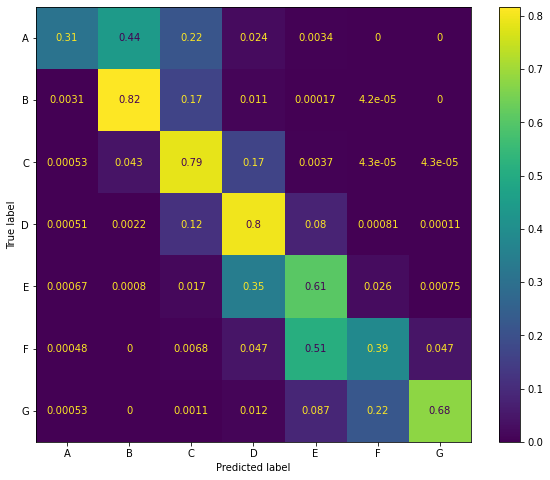

In [18]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax)

print(classification_report(y_test, y_pred))